In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse

import numpy as np
import tensorflow as tf

In [2]:
def load_graph(model_file):
  graph = tf.Graph()
  graph_def = tf.GraphDef()

  with open(model_file, "rb") as f:
    graph_def.ParseFromString(f.read())
  with graph.as_default():
    tf.import_graph_def(graph_def)

  return graph


def read_tensor_from_image_file(file_name,
                                input_height=299,
                                input_width=299,
                                input_mean=0,
                                input_std=255):
  input_name = "file_reader"
  output_name = "normalized"
  file_reader = tf.read_file(file_name, input_name)
  if file_name.endswith(".png"):
    image_reader = tf.image.decode_png(
        file_reader, channels=3, name="png_reader")
  elif file_name.endswith(".gif"):
    image_reader = tf.squeeze(
        tf.image.decode_gif(file_reader, name="gif_reader"))
  elif file_name.endswith(".bmp"):
    image_reader = tf.image.decode_bmp(file_reader, name="bmp_reader")
  else:
    image_reader = tf.image.decode_jpeg(
        file_reader, channels=3, name="jpeg_reader")
  float_caster = tf.cast(image_reader, tf.float32)
  dims_expander = tf.expand_dims(float_caster, 0)
  resized = tf.image.resize_bilinear(dims_expander, [input_height, input_width])
  normalized = tf.divide(tf.subtract(resized, [input_mean]), [input_std])
  sess = tf.Session()
  result = sess.run(normalized)

  return result


def load_labels(label_file):
  label = []
  proto_as_ascii_lines = tf.gfile.GFile(label_file).readlines()
  for l in proto_as_ascii_lines:
    label.append(l.rstrip())
  return label

In [3]:
input_folder="D:/Projects/SDC/Term3/Capstone-Project-SDC-Term3-P3-Udacity/sim-recs/src/tl_detector/"
model_file = "/tmp/output_graph.pb"
label_file = "tensorflow/examples/label_image/data/imagenet_slim_labels.txt"
input_height = 224
input_width = 224
input_mean = 0
input_std = 255
input_layer = "Placeholder"
output_layer = "final_result"
label_file = "/tmp/output_labels.txt"

input_name = "import/" + input_layer
output_name = "import/" + output_layer

graph = load_graph(model_file)

input_operation = graph.get_operation_by_name(input_name)
output_operation = graph.get_operation_by_name(output_name)
labels = load_labels(label_file)

In [4]:
def inference(sess, input_tensor, input_operation, output_operation, labels):
    results = sess.run(output_operation.outputs[0], {input_operation.outputs[0]: input_tensor})
    results = np.squeeze(results)

    top_indices = results.argsort()[-5:][::-1]
#     for i in top_indices:
#         print(labels[i], results[i])
    return results, top_indices

[INFO] program started on - 2018-09-03 20:48:16.420761
Time to run: 0:00:23.206521


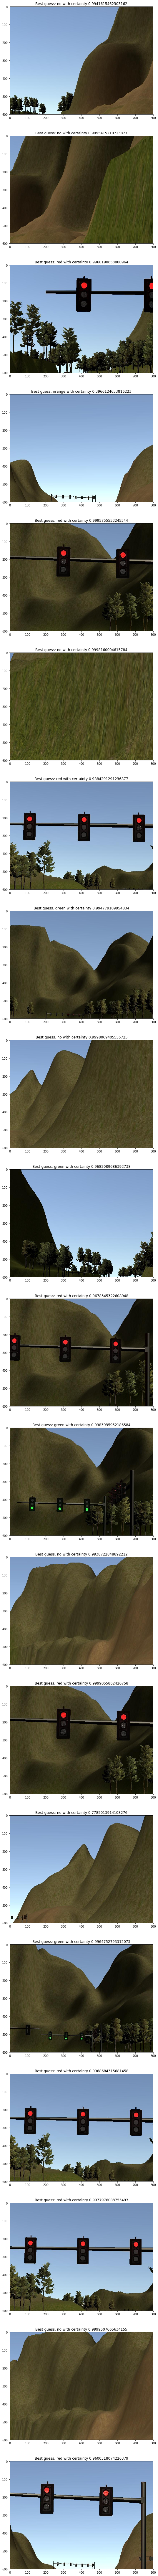

In [6]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from random import shuffle
import datetime
import glob
import os

image_paths = glob.glob(os.path.join(input_folder, "*.jpg"))
shuffle(image_paths)
start_time = datetime.datetime.now()
nr_images = 20
fig, axes = plt.subplots(nrows=nr_images, ncols=1, figsize=(28, 8 * nr_images))
print ("[INFO] program started on - " + str(start_time))

with tf.Session(graph=graph) as sess:
    for i, image_name in enumerate(image_paths[:nr_images]):
        image_tensor = read_tensor_from_image_file(
            image_name,
            input_height=input_height,
            input_width=input_width,
            input_mean=input_mean,
            input_std=input_std)
        results, top_indices = inference(
            sess=sess, 
            input_tensor=image_tensor, 
            input_operation=input_operation, 
            output_operation=output_operation,
            labels=labels)
        sorted_labels = [ labels[i] for i in top_indices]
        sorted_results = [ results[i] for i in top_indices]
        img=mpimg.imread(image_name)
        axes[i].imshow(img)
        axes[i].set_title(f'Best guess: {sorted_labels[0]} with certainty {sorted_results[0]}')

end_time = datetime.datetime.now()
time_diff = end_time - start_time
print (f"Time to run: {time_diff}")